# Hypothesis: I can figure out how clean a restaurant is by its yelp ratings. Possibly by also including type of food and location of restaurant. 
# Null hypothesis: A restaurants inspection grade and yelp ratings are not correlated at all

In [1]:
import numpy as np
import pandas as pd
import os.path
import json

import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import cross_val_score

import sklearn.metrics as skmetrics

%matplotlib inline



/Users/allandong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Gathering

Reading NYC Restaurant Inspection data into DataFrame to grab restaurant title/address to generate appropriate yelp urls for futures scraping

In [2]:
nyccsv = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/DOHMH_New_York_City_Restaurant_Inspection_Results.csv'

df = pd.read_csv(nyccsv)

cols = ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE_DESC',
           'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE', 'VIOLATION_DESC', 'CRITICAL_FLAG',
           'SCORE', 'GRADE', 'GRADE_DATE', 'RECORD_DATE', 'INSPECTION_TYPE']
df.columns = cols




Yelp URLs are formulaic, by title and address. Generate Yelp URLs for scraping with scrapy.

In [3]:
df['ADDRESS'] = df.BUILDING + " " + df.STREET + " " + df.BORO

def yelp_url_gen(row):
    # yelp_url_gen:
    #     Yelp search urls are formulatic based upon "Find" and "Location" inserted values -
    #   so, I can generate what the urls would be if I serached by restaurant title and
    #   restaurant address

    title1 = row['DBA'].replace(" ", "+")
    address1 = row['ADDRESS'].replace(" ", "+")
    return "https://www.yelp.com/search?find_desc={title1}&find_loc={address1}".format(title1=title1, address1=address1)

df_clean = df.dropna(axis=0, how='any')
df_clean['URL'] = df_clean.apply(yelp_url_gen, axis = 1)

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Export to csv for access by scrapy program yelp_ratings.py

In [4]:
path = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/df_clean.csv'
df_clean.to_csv(path)

urllist=list(df_clean['URL'])

In [5]:
df_clean.ZIPCODE = df_clean.loc[:, 'ZIPCODE'].astype(int)
df_clean.ZIPCODE = df_clean.loc[:, 'ZIPCODE'].astype(str)

/Users/allandong/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [6]:
df_clean.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESC', 'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE',
       'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE', 'GRADE', 'GRADE_DATE',
       'RECORD_DATE', 'INSPECTION_TYPE', 'ADDRESS', 'URL'],
      dtype='object')

# Data Exploration 1

Testing and cleaning code

df_stats = creating a smaller DataFrame to run regressions/plot

In [7]:
df_stats = df_clean.drop(['CAMIS', 
                          'PHONE',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'ZIPCODE', 
                          'ACTION', 
                          'VIOLATION_CODE', 
                          'VIOLATION_DESC', 
                          'INSPECTION_TYPE', 
                          'URL'
                         ], 1)


Prep variables and defining functions to create Dummy Variables 'GRADE_NUM' and 'CRIT_FLAG_NUM'

In [8]:
df_stats = df_stats[df_stats.GRADE != 'Z']
df_stats = df_stats[df_stats.GRADE != 'P']
df_stats = df_stats[df_stats.GRADE != 'Not Yet Graded']

In [9]:
def grader(row):
    grade = row['GRADE']
    if grade=='A':
        return 0
    elif grade=='B':
        return 5
    elif grade=='C':
        return 10
    
df_stats['GRADE_NUM'] = df_stats.apply(grader, axis=1)

In [10]:
def criticalflag(row):
    flag = row['CRITICAL_FLAG']
    if flag == 'Critical':
        return 1
    elif flag == 'Not Critical':
        return 0

df_stats['CRIT_FLAG_NUM'] = df_stats.apply(criticalflag, axis=1)

Drop remaining unneeded columns

In [11]:
df_stats1=df_stats.drop(['DBA',
                        'CUISINE_DESC',
                        'INSPECTION_DATE',
                        'CRITICAL_FLAG',
                        'GRADE',
                        'GRADE_DATE',
                        'RECORD_DATE',
                        'ADDRESS',
                       ], 1)

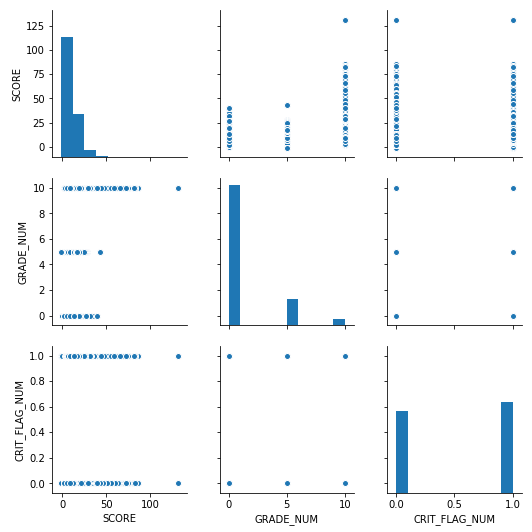

In [12]:
sns.pairplot(df_stats1[['SCORE', 'GRADE_NUM', 'CRIT_FLAG_NUM']], 
                       kind="scatter",
                       diag_kind="hist"
                       )


#### OK, score is obiously very skewed to to lower values, but critical flags vs. non_critical flag is relatively even.

<Container object of 79 artists>

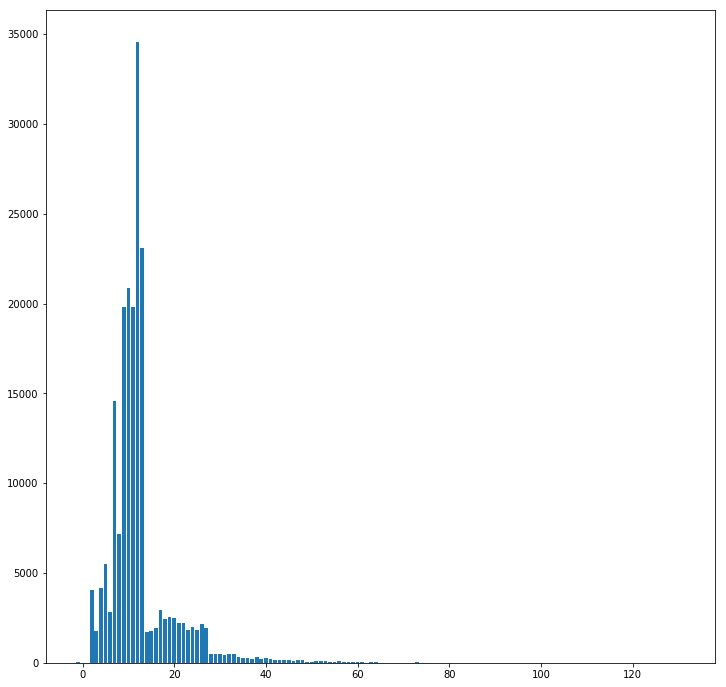

In [13]:
# Show distribution of 'SCORE' values
score = df_stats['SCORE'].value_counts()
plt.figure(figsize=(12,12))
plt.bar(score.index, score)


<Container object of 78 artists>

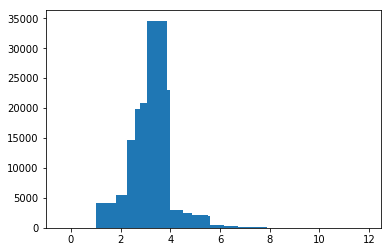

In [14]:
df_stats['Sqrt_Score'] = df_stats['SCORE'].apply(np.sqrt)
sqrtscore = df_stats['Sqrt_Score'].value_counts()
plt.bar(sqrtscore.index, sqrtscore)

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/transforms.py:436: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


<Container object of 78 artists>

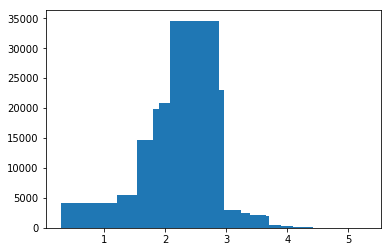

In [15]:
df_stats['Log_Score'] = df_stats['SCORE'].apply(np.log)
logscore = df_stats['Log_Score'].value_counts()
plt.bar(logscore.index, logscore)


/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/transforms.py:436: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


<Container object of 78 artists>

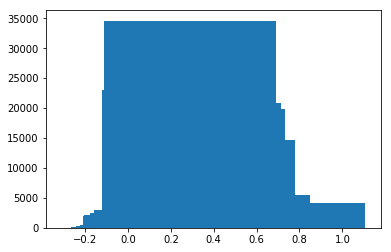

In [16]:
def one_over_sqrt(x):
    return np.reciprocal(np.sqrt(x))

df_stats['1Sqrt_Score'] = df_stats['SCORE'].apply(one_over_sqrt)
oneoversqrtscore = df_stats['1Sqrt_Score'].value_counts()
plt.bar(oneoversqrtscore.index, oneoversqrtscore)

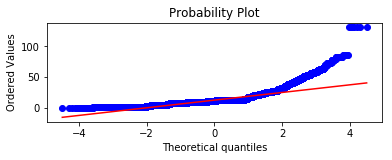

In [17]:
from scipy import stats

fig = plt.figure()
ax1= fig.add_subplot(211)
prob = stats.probplot(df_stats['SCORE'], plot=ax1)

#ax2= fig.add_subplot(212)
#prob = stats.probplot(df_stats['Log_Score'], plot=ax2)

#ax3= fig.add_subplot(212)
#xt = stats.boxcox(df_stats['SCORE'].values)
#prob = stats.probplot(xt, plot=ax3)

#score = df_stats['SCORE'].values

In [18]:
df_stats['SCORE'].values

array([27.,  9., 12., ..., 12.,  9., 13.])

# Add Yelp Data, Data Cleaning

df_yelp = Read in Yelp data as a DataFrame, and add a 'RATINGS' column that just has the rating number

In [19]:
yelp = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/yelp.csv'

df_yelp= pd.read_csv(yelp)

yelp_cols = ['URL', 'YELP_RATINGS']
df_yelp.columns = yelp_cols

df_yelp = df_yelp[df_yelp['YELP_RATINGS'] != 'yelp_ratings']

def get_num(row):
    return float(row['YELP_RATINGS'].split()[0])

df_yelp['RATINGS'] = df_yelp.apply(get_num, axis=1)


df_ex_pre_raw = Concating df_short and df_yelp and with NaN's dropped

In [20]:
df_ex_pre_raw= pd.merge(df_clean, df_yelp, how='left',on='URL')

df_ex_pre_raw = df_ex_pre_raw.drop_duplicates().dropna(axis=0, how='any')

In [21]:
df_ex_pre_raw.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESC', 'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE',
       'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE', 'GRADE', 'GRADE_DATE',
       'RECORD_DATE', 'INSPECTION_TYPE', 'ADDRESS', 'URL', 'YELP_RATINGS',
       'RATINGS'],
      dtype='object')

In [22]:
df_ex_pre = df_ex_pre_raw.drop(['BUILDING', 
                              'STREET', 
                              'PHONE',
                              'ADDRESS',
                              'URL',
                              'YELP_RATINGS'
                                 ], 1)

In [23]:
df_ex_pre.INSPECTION_DATE = pd.to_datetime(df_ex_pre.INSPECTION_DATE)

In [24]:
df_ex_pre.columns

Index(['CAMIS', 'DBA', 'BORO', 'ZIPCODE', 'CUISINE_DESC', 'INSPECTION_DATE',
       'ACTION', 'VIOLATION_CODE', 'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE',
       'GRADE', 'GRADE_DATE', 'RECORD_DATE', 'INSPECTION_TYPE', 'RATINGS'],
      dtype='object')

#### CAMIS id separates each individual reataurant

In [25]:
df_ex_pre.CAMIS.value_counts().head()

41592230    36
41705634    34
41686353    34
40392685    33
40645073    33
Name: CAMIS, dtype: int64

In [26]:
df_ex_pre[df_ex_pre.CAMIS == 41592230]

,CAMIS,DBA,BORO,ZIPCODE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,RATINGS
186017,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2015-05-28,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,27.0,B,05/28/2015,07/09/2017,Cycle Inspection / Re-inspection,3.5
407595,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2015-05-28,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,27.0,B,05/28/2015,07/09/2017,Cycle Inspection / Re-inspection,3.5
427062,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2014-07-28,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizi...,Critical,25.0,B,07/28/2014,07/09/2017,Cycle Inspection / Re-inspection,3.5
488117,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2016-05-11,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,13.0,A,05/11/2016,07/09/2017,Cycle Inspection / Initial Inspection,3.5
577921,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2014-07-28,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,25.0,B,07/28/2014,07/09/2017,Cycle Inspection / Re-inspection,3.5
582515,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2015-01-20,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,13.0,A,01/20/2015,07/09/2017,Cycle Inspection / Re-inspection,3.5
626327,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2013-05-15,Violations were cited in the following area(s).,02H,Food not cooled by an approved method whereby ...,Critical,20.0,B,05/15/2013,07/09/2017,Cycle Inspection / Re-inspection,3.5
629555,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2015-10-13,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,56.0,C,10/13/2015,07/09/2017,Cycle Inspection / Re-inspection,3.5
633521,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2013-05-15,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,20.0,B,05/15/2013,07/09/2017,Cycle Inspection / Re-inspection,3.5
692711,41592230,LA ISLA CAFE RESTAURANT,MANHATTAN,10002,"Latin (Cuban, Dominican, Puerto Rican, South &...",2013-05-15,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,20.0,B,05/15/2013,07/09/2017,Cycle Inspection / Re-inspection,3.5


In [27]:
df_ex_pre.ZIPCODE.value_counts().shape

(221,)

In [28]:
df_ex_pre.CUISINE_DESC.value_counts().shape

(84,)

#### INSPECTION_DATE and GRADE_DATE are equal, 
#### Result: we're going to remove GRADE_DATE

In [29]:
#df_ex_pre[df_ex_pre.INSPECTION_DATE != df_ex_pre.GRADE_DATE].shape

In [30]:
type(df_ex_pre.GRADE_DATE[0])

str

#### Two types of ACTION, also doesn't necessarily mean first visit
#### 

In [31]:
df_ex_pre.ACTION.value_counts()

Violations were cited in the following area(s).    119023
Establishment re-opened by DOHMH                     1199
Name: ACTION, dtype: int64

In [32]:
df_ex_pre[df_ex_pre.ACTION == 'Establishment re-opened by DOHMH'].head()

,CAMIS,DBA,BORO,ZIPCODE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,RATINGS
1570,41507172,BARI'S PIZZA & PASTA RESTAURANT,STATEN ISLAND,10304,Pizza,2014-06-26,Establishment re-opened by DOHMH,04N,Filth flies or food/refuse/sewage-associated (...,Critical,9.0,C,06/26/2014,07/09/2017,Cycle Inspection / Reopening Inspection,3.5
12141,41385384,MIMI'S HUMMUS,BROOKLYN,11218,Middle Eastern,2017-05-19,Establishment re-opened by DOHMH,10F,Non-food contact surface improperly constructe...,Not Critical,19.0,P,05/19/2017,07/09/2017,Cycle Inspection / Reopening Inspection,4.0
15832,50018728,KHAO SARN,BROOKLYN,11249,Thai,2015-09-08,Establishment re-opened by DOHMH,08A,Facility not vermin proof. Harborage or condit...,Not Critical,9.0,P,09/08/2015,07/09/2017,Cycle Inspection / Reopening Inspection,3.5
19310,41462164,CROWN FRIED CHICKEN,BROOKLYN,11216,Chicken,2016-10-25,Establishment re-opened by DOHMH,06D,"Food contact surface not properly washed, rins...",Critical,12.0,P,10/25/2016,07/09/2017,Cycle Inspection / Reopening Inspection,3.0
23219,41450971,GIOVANNI'S RESTAURANT,BRONX,10461,Pizza/Italian,2016-12-14,Establishment re-opened by DOHMH,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,Z,12/14/2016,07/09/2017,Cycle Inspection / Reopening Inspection,4.0


pre_reopen = []

def is_establishment_reopen_first_date_check(CAMIS):
    df_subset = df_ex_pre[df_ex_pre.CAMIS == CAMIS]
    re_open_date = df_subset[df_subset.ACTION == 'Establishment re-opened by DOHMH'].INSPECTION_DATE.values[0]
    s_subset = df_subset[df_subset.INSPECTION_DATE]
    for key, value in enumerate(s_subset):
        if value < re_open_date:
            pre_reopen.append(s_subset.index[key])

lst_CAMIS = df_ex_pre[df_ex_pre.ACTION == 'Establishment re-opened by DOHMH'].CAMIS.unique()

for x in lst_CAMIS:
    is_establishment_reopen_first_date_check(x)



In [33]:
df_ex_pre[df_ex_pre.GRADE =='Not Yet Graded']

,CAMIS,DBA,BORO,ZIPCODE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,RATINGS
1100414,50058720,GOOD TIMES,BROOKLYN,11209,Delicatessen,2017-02-14,Violations were cited in the following area(s).,10I,"Single service item reused, improperly stored,...",Not Critical,9.0,Not Yet Graded,02/14/2017,07/09/2017,Pre-permit (Operational) / Initial Inspection,4.0
1275524,50042785,EMPIRE SZECHUAN GARDEN,QUEENS,11104,Chinese,2016-10-21,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,6.0,Not Yet Graded,10/21/2016,07/09/2017,Pre-permit (Operational) / Initial Inspection,3.0
1362408,50042785,EMPIRE SZECHUAN GARDEN,QUEENS,11104,Chinese,2016-10-21,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,6.0,Not Yet Graded,10/21/2016,07/09/2017,Pre-permit (Operational) / Initial Inspection,3.0
1547939,50058720,GOOD TIMES,BROOKLYN,11209,Delicatessen,2017-02-14,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,9.0,Not Yet Graded,02/14/2017,07/09/2017,Pre-permit (Operational) / Initial Inspection,4.0
1693973,50058720,GOOD TIMES,BROOKLYN,11209,Delicatessen,2017-02-14,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,9.0,Not Yet Graded,02/14/2017,07/09/2017,Pre-permit (Operational) / Initial Inspection,4.0


### df_ex is now my base dataframe 

In [34]:
df_ex = df_ex_pre.drop(['INSPECTION_DATE'], 1)

df_ex = df_ex[df_ex['GRADE'] != 'Not Yet Graded']


In [35]:
df_ex.head(2)

,CAMIS,DBA,BORO,ZIPCODE,CUISINE_DESC,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,RATINGS
0,41554120,BROOKS 1890 RESTAURANT,QUEENS,11101,Italian,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,27.0,B,05/21/2014,07/09/2017,Cycle Inspection / Re-inspection,2.5
41,50003253,PARIS BAGUETTE,MANHATTAN,10022,Bakery,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,9.0,A,03/21/2016,07/09/2017,Cycle Inspection / Re-inspection,3.5


### 1. Linear Regression - Log_Score, Ratings, Critical_Flag
### Create df for linear regression

In [36]:
df_linear1 = df_ex.drop(['CAMIS',
                         'GRADE',
                         'DBA',
                         'VIOLATION_CODE',
                         'ZIPCODE',
                         'BORO',
                         'CUISINE_DESC',
                         'VIOLATION_DESC',
                         'ACTION',
                         'INSPECTION_TYPE',
                         'GRADE_DATE',
                         'RECORD_DATE'
                         ], 1)

In [37]:
df_linear2 = df_linear1[df_linear1.SCORE >0]

df_linear2['Log_Score'] = df_linear2.loc[:,'SCORE'].apply(np.log)




df_linear2 = df_linear2.drop(['SCORE'], 1)


/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
#df_linear2.loc[:'Log_Score'] 

#df_linear2[df_linear2.Log_Score <0]

In [39]:
df_lin2 = pd.get_dummies(df_linear2, drop_first = True, columns = [#'ZIPCODE', 
                                                    #'BORO', 
                                                    #'CUISINE_DESC', 
                                                    'CRITICAL_FLAG'])
df_lin2.columns

Index(['RATINGS', 'Log_Score', 'CRITICAL_FLAG_Not Critical'], dtype='object')

In [40]:
df_lin2 = df_lin2[['Log_Score', 'RATINGS', 'CRITICAL_FLAG_Not Critical']]

In [41]:
df_lin2.head(2)

,Log_Score,RATINGS,CRITICAL_FLAG_Not Critical
0,3.295837,2.5,0
41,2.197225,3.5,0


### Train Test Split/Linear Regression

In [42]:
# Dependendent Variable = 'Log_Score' - Log of Health Inspection Scores
# Independent Variables = 'RATINGS', 'CRITICAL_FLAG' dummy
df_lin2_y = df_lin2['Log_Score']
df_lin2_x = df_lin2.drop(['Log_Score'], 1)

x_train, x_finaltest, y_train, y_finaltest = train_test_split(df_lin2_x, df_lin2_y, test_size=0.2)

In [43]:
lr  = LinearRegression()
logit = LogisticRegression()


lr.fit(x_train, y_train)
lr_predict = lr.predict(x_finaltest)

In [44]:
df_lin2_x.columns #lr.coef_

Index(['RATINGS', 'CRITICAL_FLAG_Not Critical'], dtype='object')

In [45]:
lr.coef_

array([-0.01287681, -0.26516873])

In [46]:
lr.score(x_finaltest, y_finaltest)

0.06795616256831438

In [47]:
print("Explained variance score: %s" % skmetrics.explained_variance_score(y_finaltest, lr_predict))

print("Mean squared error: %s" % skmetrics.mean_squared_error(y_finaltest, lr_predict))

print("R2 score: %s" % skmetrics.r2_score(y_finaltest, lr_predict))

Explained variance score: 0.06800643683871166
Mean squared error: 0.2680828841246879
R2 score: 0.06795616256831438


#### Explained variance score: 0.06800643683871166
#### Mean squared error: 0.2680828841246879
#### R2 score: 0.06795616256831438

#### Wow, that R2 value is almost 0. This basically implies Log Score and Critical Flag has zero linear relations with Ratings. Lets run a correlation Coefficient

In [49]:
df_lin2.corr()

,Log_Score,RATINGS,CRITICAL_FLAG_Not Critical
Log_Score,1.000000,-0.013244,-0.249923
RATINGS,-0.013244,1.000000,-0.013828
CRITICAL_FLAG_Not Critical,-0.249923,-0.013828,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c156e0710>,
      dtype=object)

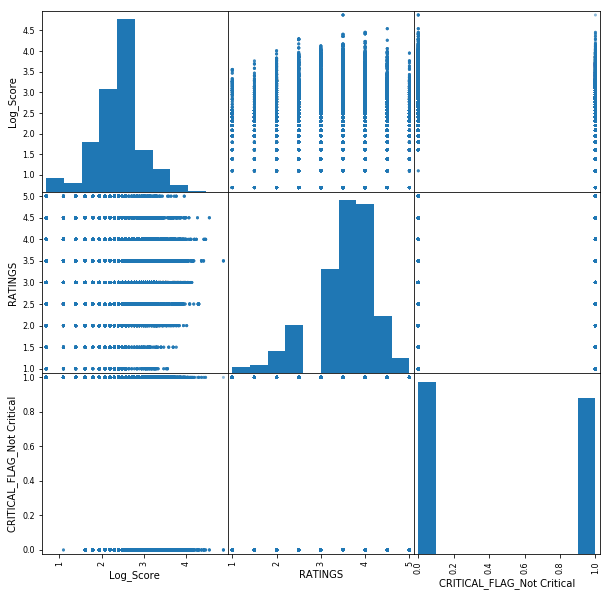

In [50]:
pd.plotting.scatter_matrix(df_lin2, alpha = 0.5, figsize = (10, 10))

### 2. Linear Regression - Log Score, Ratings, Critical Flag, Zipcode, Cuisine_desc, Violation_code
### New df for linear regression

In [44]:
df_linear3_ex = df_ex.drop(['CAMIS',
                            'BORO',
                            'GRADE',
                            'DBA',
                            'VIOLATION_DESC',
                            'ACTION',
                            'INSPECTION_TYPE',
                            'GRADE_DATE',
                            'RECORD_DATE'
                         ], 1)

df_linear3 = df_linear3_ex[df_linear3_ex.SCORE > 0]

In [45]:
df_linear3.columns

Index(['ZIPCODE', 'CUISINE_DESC', 'VIOLATION_CODE', 'CRITICAL_FLAG', 'SCORE',
       'RATINGS'],
      dtype='object')

In [46]:
df_linear3['Log_Score'] = df_linear3.loc[:,'SCORE'].apply(np.log)
df_linear3_1hot = pd.get_dummies(df_linear3, drop_first = True, columns = ['ZIPCODE', 
                                                                           'CUISINE_DESC', 
                                                                           'VIOLATION_CODE',
                                                                           'CRITICAL_FLAG'],)


/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
# print(list(df_linear3_1hot.columns))

In [48]:
df_lin3 = df_linear3_1hot.drop(['SCORE'], 1)

In [49]:
df_lin3_y = df_lin3['Log_Score']
df_lin3_x = df_lin3.drop(['Log_Score'], 1)


x_train3, x_test3, y_train3, y_test3 = train_test_split(df_lin3_x, df_lin3_y, test_size=0.2)

In [50]:
lr = LinearRegression()

lr.fit(x_train3, y_train3)
lr_predict3 = lr.predict(x_test3)

In [51]:
lr.score(x_test3, y_test3)

0.19110349694471662

In [52]:
print("Explained variance score/R2: %s" % skmetrics.explained_variance_score(y_test3, lr_predict3))

print("Mean squared error: %s" % skmetrics.mean_squared_error(y_test3, lr_predict3))

print("R2 score: %s" % skmetrics.r2_score(y_test3, lr_predict3))

Explained variance score/R2: 0.19121331557780852
Mean squared error: 0.22928323036359607
R2 score: 0.19110349694471662


#### Explained variance score/R2: 0.19922667527359117
    
#### Mean squared error: 0.22724405308413398
    
#### R2 score: 0.19922598269970815

In [53]:
# R2 score higher this time, but still produces a poor model to predict Log_Score.
# Increased number of features also likely to have caused higher R2 score

In [ ]:
cross_val_score(lr, df_lin3_x, df_lin3_y, cv=5)

In [ ]:
# Huh, is there really no correlation betwen score and any of these categories? Plot Predicted vs Actual values

In [ ]:
real_predict = pd.Series(np.exp(lr_predict3), name = 'real_predict')
real_y_test3 = pd.Series(np.exp(y_test3),name = 'real_test')


#real_y_test3['Real_Predict'] = real_predict

df_real_predict = pd.DataFrame(real_y_test3).join(real_predict)



In [ ]:
# Plot log_predicted vs log_actual values
x = lr_predict3
y = y_test3

plt.scatter(x, y)

In [ ]:
# Plot predicted vs actual values
x = real_predict
y = real_y_test3

plt.scatter(x, y)

In [ ]:
# Plot residuals of log_predicted

lr_residuals = lr_predict3 - y_test3

x = lr_predict3
y = lr_residuals

plt.scatter(x, y)

In [ ]:
# Plot residuals of actual_predicted

real_residuals = real_predict - real_y_test3

x = real_predict
y = real_residuals



In [ ]:
lr_residuals.head()

In [52]:
def kfolds_cv(x, y, n):
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    trainsets = []
    testsets = []
    for train, test in kf.split(x, y):
        trainsets.append(train)
        testsets.append(test)
    return trainsets, testsets

trainsets, testsets = kfolds_cv(x_train, y_train, 5)

In [53]:


#for i in range(0, len(trainsets)):
#    print(lr.fit(trainsets[i], testsets[i]).score)

In [ ]:
def modelprints(algo, X, y, trainfold, testfold):
    algs = algo()
    fitted_model = algs.fit(X.iloc[trainfold], y[trainfold])
    yhat = algs.predict_proba(X.iloc[testfold])
    accuracy = algs.score(X.iloc[testfold], y[testfold])
    auscore = roc_auc_score(y[testfold],yhat[:,1])
    print('for fold '+ str(i+1) + ' accuracy = ' + str(accuracy) + ' and auc score = ' + str(auscore))
    
def modelfits(algo, X, y, trainfold, testfold):
    algs = algo()
    fitted_model = algs.fit(X.iloc[trainfold], y[trainfold])
    yhat = algs.predict_proba(X.iloc[testfold])
    return yhat[:,1]

In [ ]:
for i in range(0, len(trainsets)):
    print('\nFor fold '+ str(i+1) + ':')
    print('Log Reg  : ', end='')
    modelprints(LogisticRegression(), df_lin2_x, logscore, trainsets[i], testsets[i])


Remove all grades with that are not A, B or C

In [ ]:
dfex_cols_viol = ['RATINGS', 'SCORE', 'CRITICAL_FLAG', 'GRADE', 'VIOLATION_CODE']
dfex_viol_pre = df_ex[dfex_cols_viol]


df_ex_prex = df_ex.drop(['ZIPCODE', 'CUISINE_DESC', 'URL', 'YELP_RATINGS'],
           axis = 1)



In [ ]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=dfex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=dfex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=dfex, return_type="dataframe").drop('Intercept', 1)



In [ ]:
dfex_patsy = pd.concat([dfex, grade_num_patsy, critical_flag_patsy, violation_code_patsy], 
                      axis = 1, join_axes = [dfex.index])




dfex = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG', 'VIOLATION_CODE'], 1)
dfex_viol = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG'], 1)


In [ ]:


#cuisine_desc = pd.get_dummies(df_exx['CUISINE_DESC'])
#critical_flag = pd.get_dummies(df_exx['CRITICAL_FLAG'])
#grade_num = pd.get_dummies(df_exx['GRADE'])




In [ ]:
df_exx = df_ex_prex


critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_exx, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_exx, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_exx, return_type="dataframe").drop('Intercept', 1)


#df_exx = pd.concat([df_exx, grade_num, critical_flag], axis = 1, join_axes = [df_exx.index])
df_exx = pd.concat([df_exx, 
                    grade_num_patsy, 
                    critical_flag_patsy, 
                    violation_code_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_exx = df_exx.drop(['VIOLATION_CODE', 'CRITICAL_FLAG', 'GRADE'],
           axis = 1)




In [ ]:
dfex_patsy.head()

Check each column for non numeric values

Examine data and preliminary analysis of R2

In [ ]:
sns.set_context("paper")
sns.pairplot(dfex_patsy[['SCORE','RATINGS', 'GRADE[T.B]', 'GRADE[T.C]',
       'CRITICAL_FLAG[T.Not Critical]']], kind="scatter", diag_kind="hist")


In [ ]:
dfex_patsy.rename(columns={'CRITICAL_FLAG[T.Not Critical]':'CRITICAL_FLAG[T.NotCritical]'}, inplace=True)

In [ ]:
dfex.corr()

In [ ]:
dfex_patsy

In [ ]:
y, X = patsy.dmatrices('RATINGS ~ SCORE + RATINGS + GRADE[T.B] + GRADE[T.C] + CRITICAL_FLAG[T.NotCritical]', 
                       data=dfex_patsy, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()


#lml = smf.ols('Y ')

Check R2 with LinearRegression


Legend:

dfex : [y = 'RATINGS', x = 'SCORE', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex1 : [y = 'SCORE', x ='RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex2 : [y = 'SCORE', x ='RATINGS', 'CRIT_FLAG_NUM']

dfex1_viol : [y = 'SCORE', x = 'RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

dfex2_viol : [y = 'SCORE', x = 'RATINGS', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

In [ ]:

dfex1_cols = ['SCORE', 'RATINGS', 'GRADE[T.B]', 'GRADE[T.C]', 'CRITICAL_FLAG[T.Not Critical]']
dfex1= dfex_patsy[dfex1_cols]


dfex1_viol = dfex_patsy

In [ ]:
dfex2 = dfex1.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
dfex2_viol = dfex1_viol.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)


In [ ]:
lr = LinearRegression()
X = dfex1.iloc[:, 1:]
y = dfex1.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
lr = LinearRegression(fit_intercept = True)





X = dfex2.iloc[:, 1:]
y = dfex2.SCORE
lr.fit(X,y)
lr.score(X,y)
#print('X: ', list(X))
#print(dfex2.columns)

In [ ]:
dfex2.columns

In [ ]:

X = dfex1_viol.iloc[:, 1:]
y = dfex1_viol.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
X = dfex2_viol.iloc[:, 1:]
y = dfex2_viol.iloc[:, 0]

lr.fit(X,y)
lr.score(X,y)

In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str


In [ ]:
dfex_patsy.columns

In [ ]:
dfex_patsy1 = dfex_patsy.drop(['GRADE', 'VIOLATION_CODE', 'CRITICAL_FLAG'],1 )

y_dfex2 = dfex_patsy1.SCORE
X_dfex2 = dfex_patsy1.drop(['SCORE'], 1)

model_dfex2 = sm.OLS(y_dfex2, X_dfex2)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


In [ ]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_ex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_ex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)
zipcode_patsy = patsy.dmatrix('ZIPCODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)

df_dummy_cgvz = pd.concat([df_ex, 
#                      grade_num_patsy, 
#                      critical_flag_patsy, 
#                      violation_code_patsy,
                      zipcode_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_dummy_cgvz = df_dummy_cgvz.drop(['VIOLATION_CODE', 
                                    'CRITICAL_FLAG', 
                                    'GRADE', 
                                    'ZIPCODE', 
                                    'CUISINE_DESC',
                                    'URL',
                                    'YELP_RATINGS'
                                   ],axis = 1)

df_dummy_cgvz.columns


In [ ]:
master = dfex2
#df_dummy_cgvz
y = master.SCORE
X= master.drop(['SCORE'], 1)

print(X.columns)

model_dfex2 = sm.OLS(y, X)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


In [ ]:
df_ex.columns

In [ ]:
lr = LinearRegression()

df_exx_lr= df_exx.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
X = df_exx_lr.drop(['RATINGS'], 1)
y = df_exx_lr.RATINGS

lr.fit(X, y)
lr.score(X, y)

In [ ]:
df_exx_lr.columns

In [ ]:
reg = LinearRegression()
X = df_exx.iloc[:, 1:]
y = df_exx.iloc[:, 0]
scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

In [ ]:
sns.pairplot(dfex_patsy[['SCORE', 'RATINGS','GRADE[T.B]','GRADE[T.C]','CRITICAL_FLAG[T.Not Critical]']], 
                       kind="scatter",
                       diag_kind="hist"
                       )


In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str

In [ ]:
'''y, X = patsy.dmatrices(dfex2_viol_patsy_str,
                       data=dfex2_viol, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()
'''

In [ ]:
'''df_exx_cols = ''
for i in df_exx.columns:
    df_exx_cols += i + " + "
df_exx_cols = "SCORE ~ " + df_exx_cols[8:-3] 
df_exx_cols'''

In [ ]:
'''y_df_exx, X_df_exxx = patsy.dmatrices(df_exx_cols, data=df_exx, return_type="dataframe")
model_df_exx = sm.OLS(y_df_exx, X_df_exx)
fit_df_exx = model_df_exx.fit()
fit_df_exx.summary()'''

# Violation Code

In [ ]:
df_viol = df_clean.drop(['CAMIS', 
                          'DBA',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'ZIPCODE',
                          'PHONE',
                          'CUISINE_DESC',
                          'INSPECTION_DATE',
                          'ACTION',
                          'SCORE',
                          'GRADE',
                          'GRADE_DATE',
                          'RECORD_DATE',
                          'INSPECTION_TYPE',
                          'ADDRESS',
                          'URL'
                         ], 1)
df_viol = df_viol.drop_duplicates(subset='VIOLATION_CODE')
df_viol =df_viol.sort_values(['VIOLATION_CODE'])
df_viol.head(60)


# Data Exploration 2/2

In [ ]:
df_ex.head()

In [ ]:
sns.set_context("talk")
score = dfex_viol['SCORE']
sns.distplot(score, kde = False)

In [ ]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1)

In [ ]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1, ax = (16, 30))

In [ ]:

score = dfex_viol['SCORE']
sns.distplot(score)

In [ ]:
data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])
y = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']



# Plot

In [ ]:
x =df_ex.SCORE
y = df_ex.RATINGS

sns.regplot(x, y)

In [ ]:
sns.regplot(y, x)

In [ ]:
x =df_ex.SCORE
y = df_ex.RATINGS.apply(,1)

sns.regplot(x, y)